# TOC:
* [Imports](#imports)
* [Util Methods & Constants](#utils)
* [Load Data](#load-data)
    * [Load pre processed training data](#load-data)
        *   [Split data](#split-data)
    * [Load daily stock data](#load-daily-data)
* [Create testsplits](#create-test-splits)
* [Trade Simulations](#trade-simulations)
* [Train regressors  & run trading simulations](#train-regressors)
* [Analysis](#analysis)
    * [Confusion matrixes](#cm)
    * [Feature importances](#feature-importances)
    * [Accuracy Precission Recall](#apr)
    * [Analyze trade runs](#analyze_trade_runs)


# Imports <a class="anchor" id="imports"></a>

In [95]:
from sklearn.model_selection import train_test_split , ShuffleSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
import random

import backtrader as bt

import matplotlib.pyplot as plt
from tabulate import tabulate
from mlxtend.plotting import plot_confusion_matrix

# Util methods & Constants <a class="anchor" id="utils"></a>

In [96]:
# Constants
predict_variables = ['1Month','3Months','6Months','1Year','2Years']
meta_variables =  ['date', 'symbol', 'source']
non_test_variables = predict_variables + meta_variables
train_variables = ["Day1Prior","Day2Prior","Day3Prior","Day4Prior","Day5Prior","Day6Prior","Week1Prior","Week2Prior","Week3Prior","Month1Prior","Month2Prior","Month3Prior","Month4Prior","Month5Prior","Month6Prior","Month7Prior","Month8Prior","Month9Prior","Month10Prior","Month11Prior","Month12Prior","Month13Prior","Month14Prior","Month15Prior","Month16Prior","Month17Prior","Month18Prior","Month19Prior","Month20Prior","Month21Prior","Month22Prior","Month23Prior","Month24Prior"]

short_value = -1
long_value = 0
test_size = 0.4

enable_debug_prints = False
run_random = False

bcolors = ['\033[95m', '\033[94m', '\033[91m', '\033[92m', '\033[93m']
bcolors_end = '\033[0m'

In [97]:
# Util methods

# Method to find nearest date to a given pivot
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

# Classifies a varibale based on a string value
def classify_string(x):
    if(x == 'short'):
        return short_value
    elif(x == 'long'):
        return long_value
    else:
        return

# Classifies a variable based on numeric value
def classify(x):
    if(x < (short_value+long_value)/2):
        return short_value
    else:
        return long_value

# Evaluates a tarding run and retuns differnt quantified metrics
def evalute_overall_profit(df):
    total = 0
    positive_trades = 0
    negative_trades = 0
    long_trades = 0
    short_trades = 0 
    profit_long = 0
    profit_short = 0
    total_trades = 0
    for symbol in df: 
        total = total + df[symbol]['profit_percentage']
        if df[symbol]['profit_percentage'] > 0:
            positive_trades += 1
        else:
            negative_trades += 1
    
        if df[symbol]['strategy'] == 'long':
            long_trades += 1
            profit_long += df[symbol]['profit_percentage']
        else:
            short_trades += 1
            profit_short += df[symbol]['profit_percentage']
        total_trades += 1

    return({'total': total, 'positive_trades':positive_trades, 'negative_trades':negative_trades, 
            'long_trades':long_trades, 'short_trades': short_trades,
            'profit_long': profit_long, 'profit_short': profit_short,
            'total_trades': total_trades})

# Load data <a class="anchor" id="load-data"></a>
## Load pre processed training data <a class="anchor" id="load-data"></a>


In [98]:
classified_data = pd.read_csv('csv/table_short_long.csv',sep=',')
u_symbol = classified_data['SYMBOL'].unique()
date = pd.Series(classified_data['Date'])
classified_data.drop(['Date'],axis=1,inplace=True)
classified_data['date'] = date.apply(lambda x: np.datetime64(x))
classified_data.rename(columns={"SYMBOL": "symbol"}, inplace=True)
for variable in predict_variables:
    classified_data[variable] = classified_data[variable].apply(lambda x: classify_string(x))
classified_data[0:2]

,symbol,1Month,3Months,6Months,1Year,2Years,Day1Prior,Day2Prior,Day3Prior,Day4Prior,...,Month17Prior,Month18Prior,Month19Prior,Month20Prior,Month21Prior,Month22Prior,Month23Prior,Month24Prior,source,date
0,ALT,NaN,NaN,NaN,NaN,NaN,0.065012,-0.133654,-0.136973,-0.136973,...,-0.340892,-0.502210,-0.199111,-0.001109,0.794821,0.722753,0.371385,0.202937,Kerrisdale Capital,2024-02-14
1,JOBY,-1.0,0.0,NaN,NaN,NaN,-0.067073,-0.055556,-0.054096,-0.054096,...,0.148218,0.176923,0.256674,0.277662,0.071804,-0.098675,-0.337662,-0.322259,Kerrisdale Capital,2023-10-11


### Split data into individual datasets  <a class="anchor" id="split-data"></a>
* Spliting data into individual datasets so that each prediction period can be trained with the maximum amount of data not including NaN
* We also drop rows with NaN values in the colums we train on

In [99]:
split_classification_data = {}
classification_data_before_and_after_drop = {}
before_drop = len(classified_data)
# we drop rows with NaN values for each predict variable. So if there is NaN for 2 Years but not for 6Months, 6Months can be trained on that data
for variable in predict_variables:
    entry = {}
    entry['before_drop'] = before_drop
    split_classification_data[variable] = classified_data.dropna(subset=[variable]+train_variables)
    entry['after_drop'] = len(split_classification_data[variable])
    classification_data_before_and_after_drop[variable] = entry

for index, row in classification_data_before_and_after_drop.items():
    print("Variable: {0}  \t before drop: {1}\t after drop: {2}".format(index,row['before_drop'],row['after_drop']))

Variable: 1Month  	 before drop: 448	 after drop: 306
Variable: 3Months  	 before drop: 448	 after drop: 302
Variable: 6Months  	 before drop: 448	 after drop: 288
Variable: 1Year  	 before drop: 448	 after drop: 266
Variable: 2Years  	 before drop: 448	 after drop: 225


## Load daily stock data <a class="anchor" id="load-daily-data"></a>

In [100]:
# Daily data
clean_data = pd.read_csv('csv/clean_data_new.csv',sep=',')
u_symbol = clean_data['symbol'].unique()
date = pd.Series(clean_data['datetime'])
clean_data.drop(['datetime'],axis=1,inplace=True)
clean_data['date'] = date.apply(lambda x: np.datetime64(x))

stock_data = {}
for symbol in u_symbol:
    stock_data[symbol] = clean_data[clean_data['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]][0:2]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.3,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.5,33.73,2797160.0,1179.HK,0.026740,2020-09-24


# Create test splits<a class="anchor" id="create-test-splits"></a>
* We create a specific sorted test split for each training variable

In [101]:
classified_test_splits = {}
for variable in predict_variables:
    # We sort the array to prevent having future data in training set. 
    sorted_data = split_classification_data[variable].sort_values(['date'], ascending= True)
    train, test = train_test_split(sorted_data, test_size=test_size, shuffle = False)
    classified_test_splits[variable] = {'train': train, 'test': test}
    # Making sure we got no overlap
    if(train['date'].iloc[0] >= train['date'].iloc[-1]):
        raise Exception("First date of training data is higher than last date") 
    if(test['date'].iloc[0] >= test['date'].iloc[-1]):
        raise Exception("First date of test data is higher than last date") 
    if(train['date'].iloc[-1] >= test['date'].iloc[0]):
        raise Exception("Overlap of training and test data")
    if(enable_debug_prints):
        print("First date of \033[92mtraining\033[0m data: \t{0}".format(train['date'].iloc[0]))
        print("Last date of \033[92mtraining\033[0m data:  \t{0}".format(train['date'].iloc[-1]))
        print("First date of \x1b[31mtest\x1b[0m data:     \t{0}".format(test['date'].iloc[0]))
        print("Last date of \x1b[31mtest\x1b[0m data:      \t{0}".format(test['date'].iloc[-1]))
classified_test_splits[list(classified_test_splits.keys())[0]]['train'][0:1]

,symbol,1Month,3Months,6Months,1Year,2Years,Day1Prior,Day2Prior,Day3Prior,Day4Prior,...,Month17Prior,Month18Prior,Month19Prior,Month20Prior,Month21Prior,Month22Prior,Month23Prior,Month24Prior,source,date
145,BDBD,-1.0,0.0,0.0,0.0,0.0,-0.028139,0.033372,-0.016429,-0.016429,...,0.358548,0.866944,0.733591,0.691149,0.781746,0.799599,1.017978,1.158654,Spruce Point Capital,2013-03-06


# Trade simulations <a class="anchor" id="trade-simulations"></a>
* Trade functions take a dataset and a regressor then simulates a simple trading strategy

In [102]:
# A strategy that will go long if regressor predicts long and short if it predicts short
# If rnd is enabled will trade randomly
def trade_long_and_short(test, regressor, subset, rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['symbol'] == row['symbol']].drop(non_test_variables, axis=1)[subset])
            prediction = regressor.predict(x)[0]
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['symbol']]

        # Get the first date after short selling report
        entry_date = row['date']
        entry_pivot = nearest(np.array(df['date']),entry_date)
        entry_data = df[df['date'] == entry_pivot]
        entry_price = (entry_data['high'].values[0] + entry_data['low'].values[0])/2

        exit_date = row['date'] + np.timedelta64(365,'D')
        # Get the first date 2 years after entring the market
        exit_pivot = nearest(np.array(df['date']), exit_date)
        exit_data = df[df['date'] == exit_pivot]
        exit_price = (exit_data['high'].values[0] + exit_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction == long_value):
            # long
            profit = exit_price - entry_price
            profit_percentage = profit/ entry_price * 100
        else:
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'long' if prediction > 0 else 'short'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        returns[row['symbol']] = result
    return(returns)

# Train regressors & run trading simulations <a class="anchor" id="train-regressors"></a>

In [103]:
# A list of subsets containing the indexes of the training variables we want to train on
train_subsets = []
train_subsets.append(np.arange(0,33)) # all features
train_subsets.append([0,3,9,1,10,7,8,15,14,12]) # top that performed the best with 2Years
regressors = {}
subset_index = 0
for subset in train_subsets:
    subset_regressors = {}
    cm_regressors = {}
    for variable in predict_variables:
        df = classified_test_splits[variable]
        train = df['train']
        test = df['test']
        # select the subset of trainingvariables 
        train_subset = [train_variables[i] for i in subset]
        x_train = np.array(train.drop(non_test_variables,axis=1)[train_subset])
        y_train = np.array(train[variable])
        x_test = np.array(test.drop(non_test_variables,axis=1)[train_subset])
        y_test = np.array(test[variable])

        # Define classifier
        regressor = xgb.XGBRegressor()
        # Train on trainsplit
        regressor.fit(x_train,y_train)
        # Create confusion matrix
        labels = [long_value,short_value]
        y_pred = np.array(list(map(classify, regressor.predict(x_test))))
        cm = confusion_matrix(y_pred, y_test,labels=labels)

        # Run trading simulation
        #%TODO itterate trough all strategies and put it in a dict
        trading_result = trade_long_and_short(test, regressor=regressor, subset=train_subset)
    
        subset_regressors[variable] = {'regressor': regressor, 'confusion_matrix': cm, 'y_test': y_test, 'y_pred': y_pred, 'trading_result': trading_result}
    regressors[subset_index] = subset_regressors
    subset_index += 1

# Analysis <a class="anchor" id="analysis"></a>

## Confusion matrixes <a class="anchor" id="cm"></a>

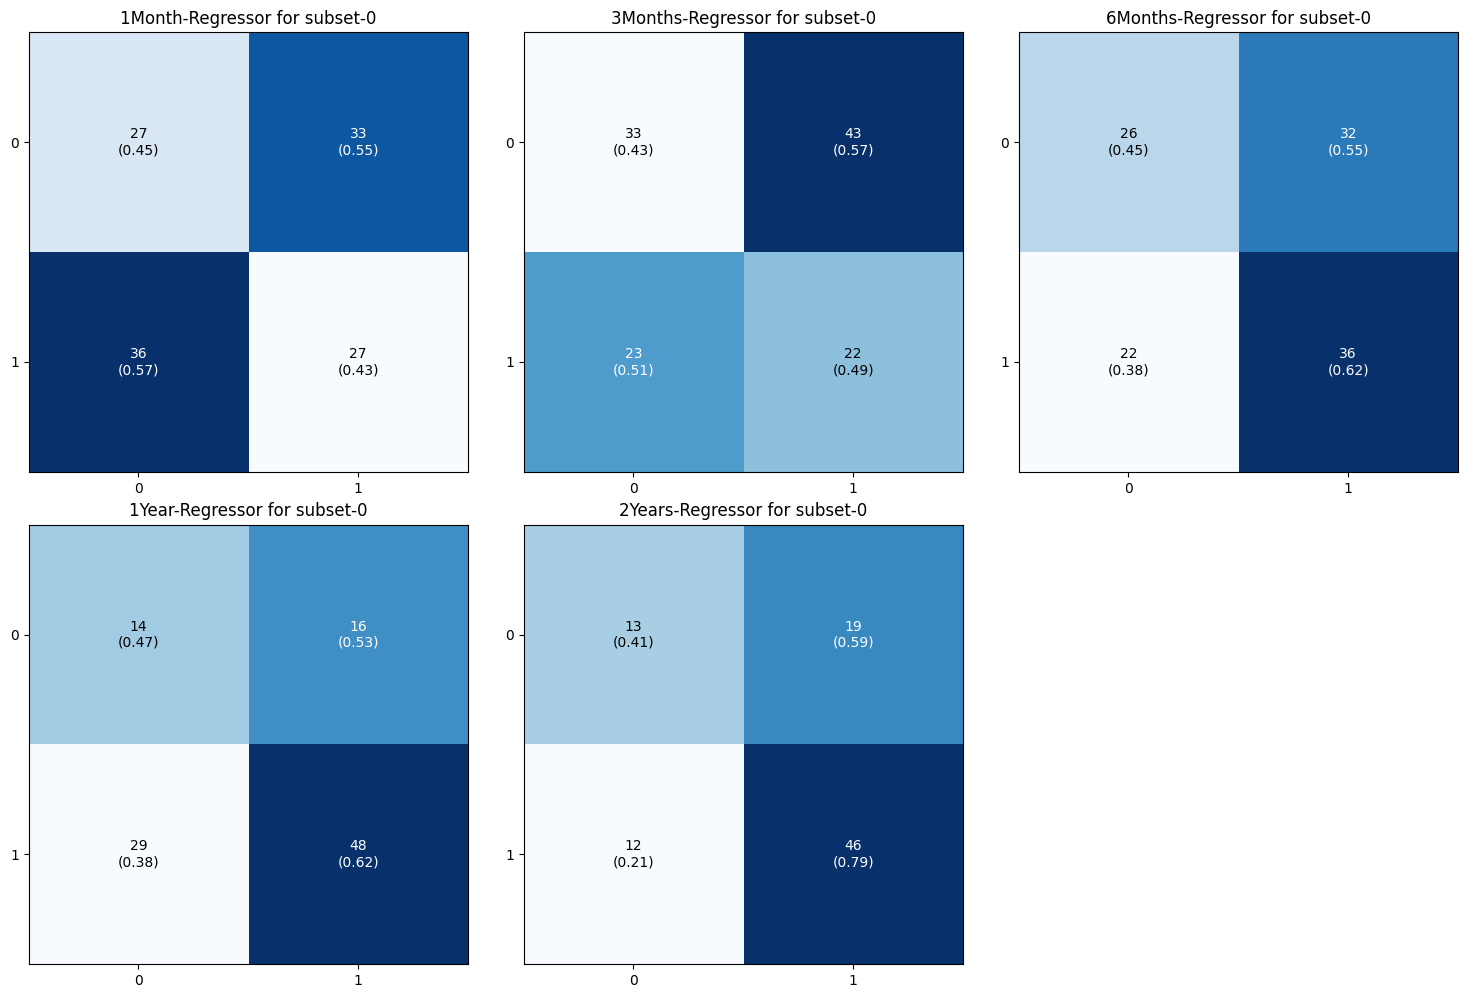

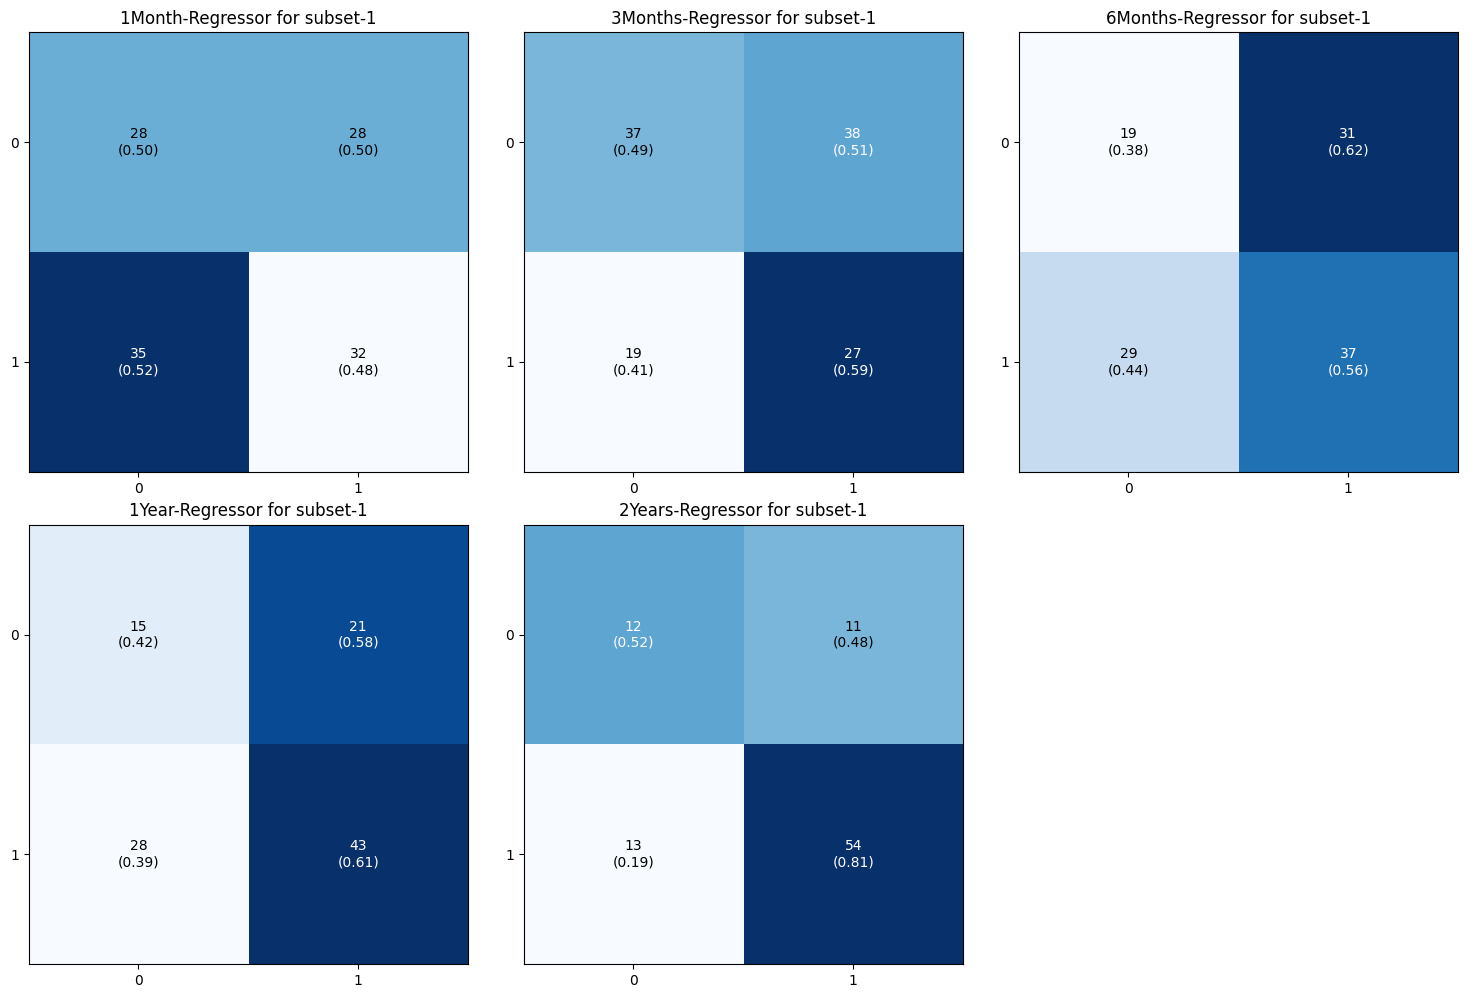

In [111]:
# Checking Confusion matrixes
for index in regressors:
    cms = []
    for key in regressors[index].keys():
        cms.append({'cm': regressors[index][key]['confusion_matrix'], 'key': key, 'index': index})

    # Print confusion matrixes
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    for cm, ax in zip(cms, axes.flatten()):
        plot_confusion_matrix(conf_mat=cm['cm'], 
                            cmap='Blues',
                            axis=ax,
                            show_normed=True,
                            )
        ax.title.set_text("{1}-Regressor for subset-{0}".format(cm['index'],cm['key']))
    # blanks last axis
    axes[1][2].axis('off')
    plt.tight_layout()  
    plt.show()


## Feature importances <a class="anchor" id="feature-importances"></a>

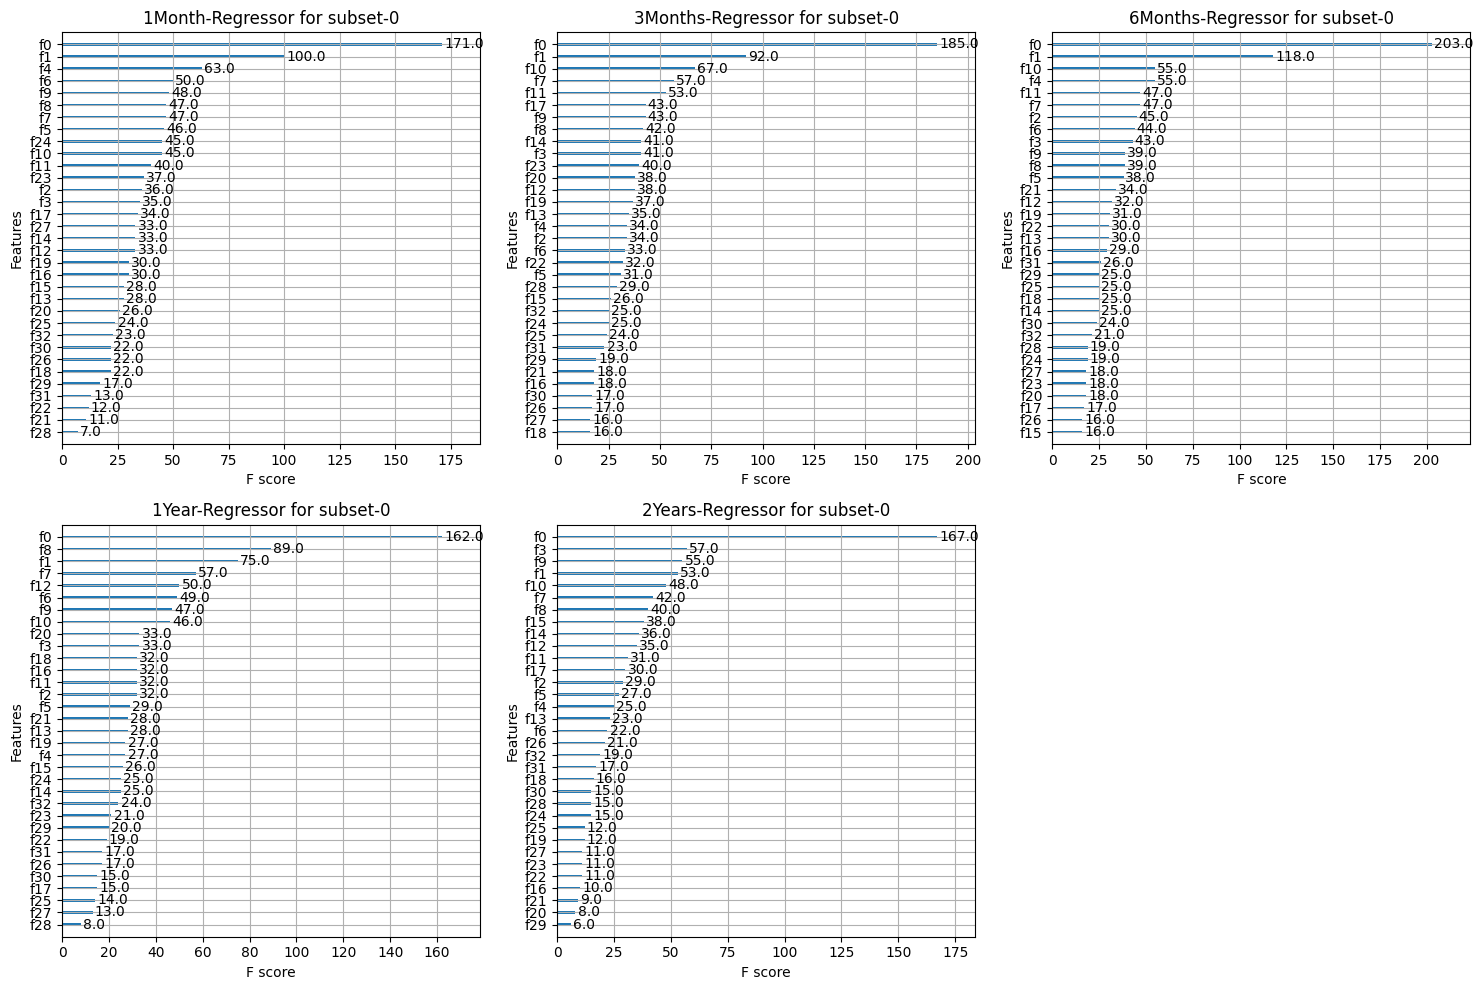

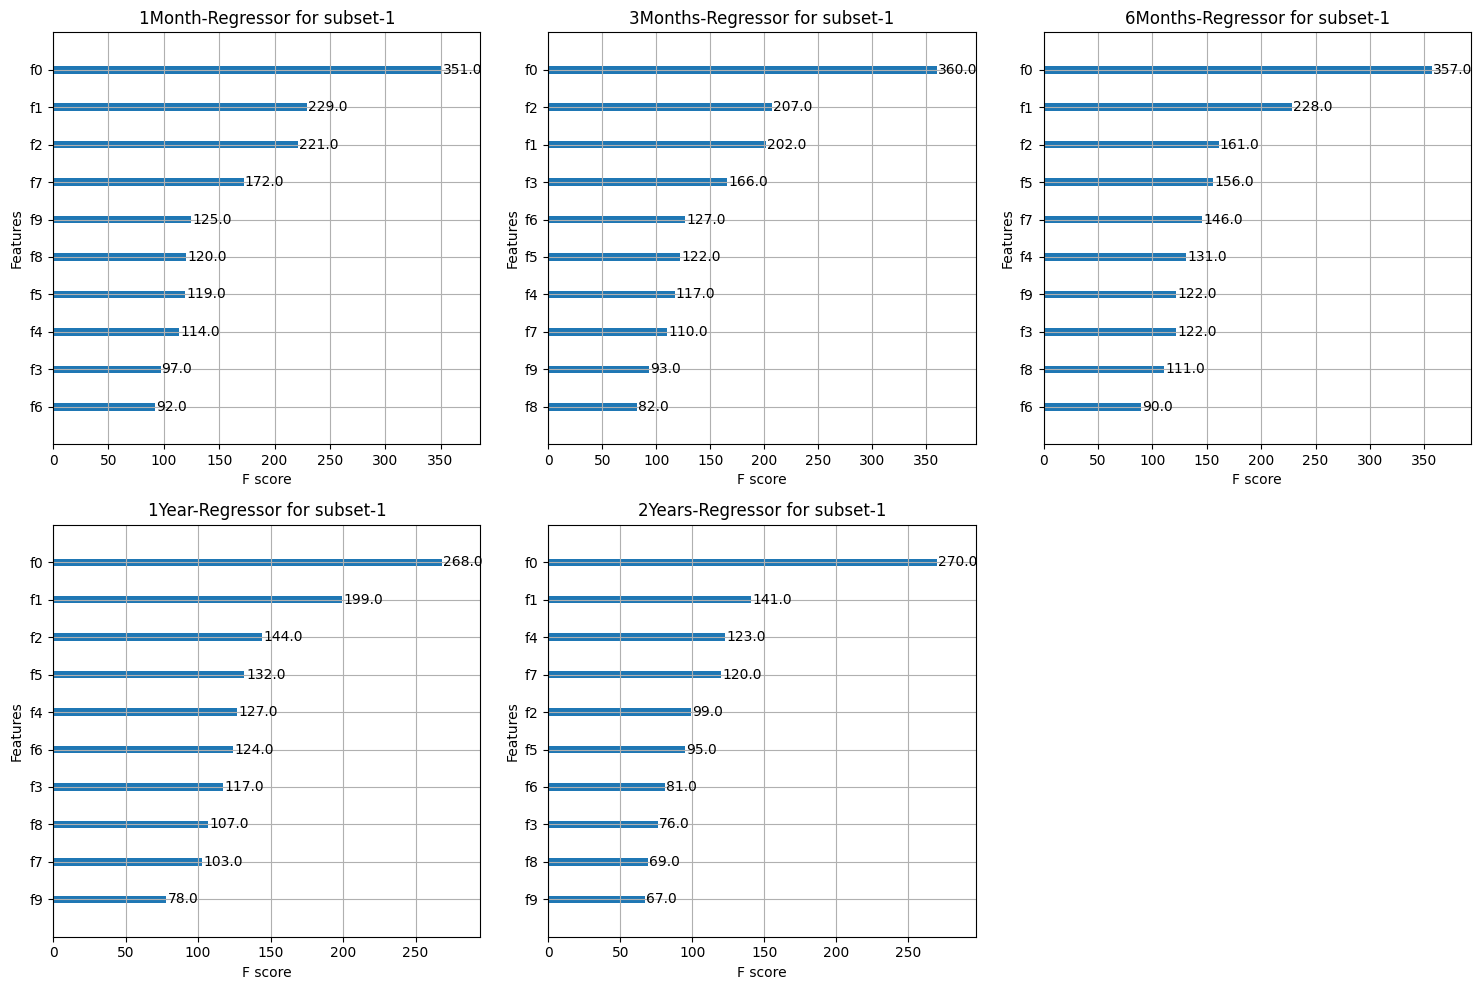

In [112]:
for index in regressors:
    rgs = []
    for key in regressors[index].keys():
        rgs.append({'regressor': regressors[index][key]['regressor'],'key': key, 'index': index})

    # Print feature importances
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    for rg, ax in zip(rgs, axes.flatten()):
        plot_importance(rg['regressor'],ax=ax)
        ax.title.set_text("{1}-Regressor for subset-{0}".format(rg['index'],rg['key']))
    # blanks last axis
    axes[1][2].axis('off')
    plt.tight_layout()  
    plt.show()

In [106]:
# from sklearn.feature_selection import SelectFromModel
# selection = SelectFromModel(regressors[0]['2Years']['regressor'], threshold=0.03, prefit=True)
# gb.plot_importance(booster=gbm )
# plt.show()
# print(selection)

NameError: name 'gb' is not defined

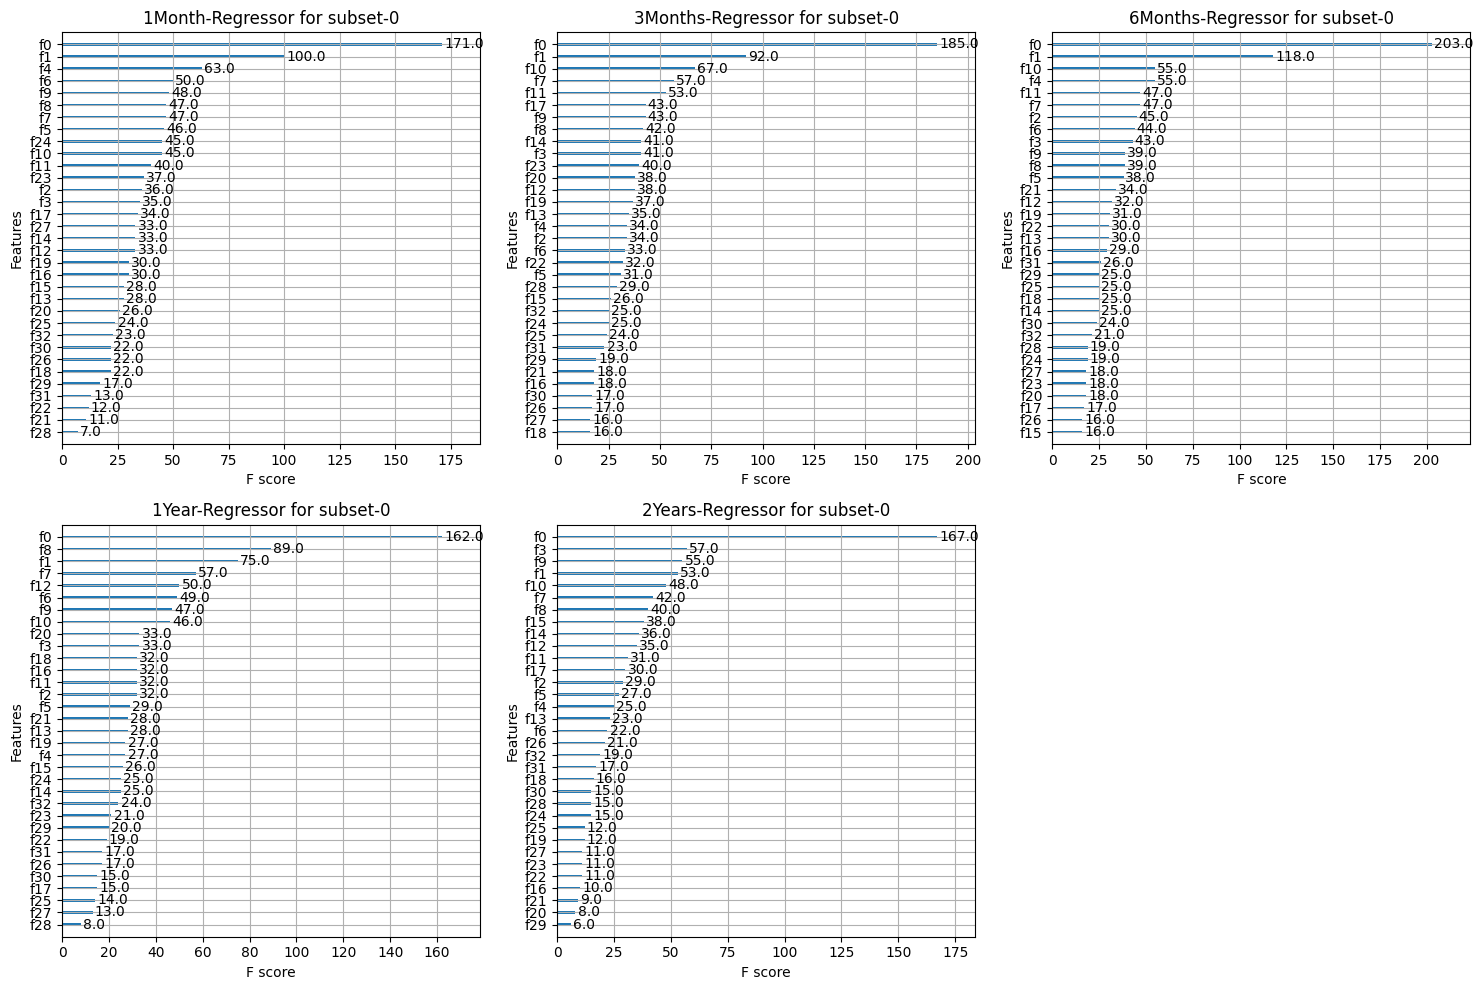

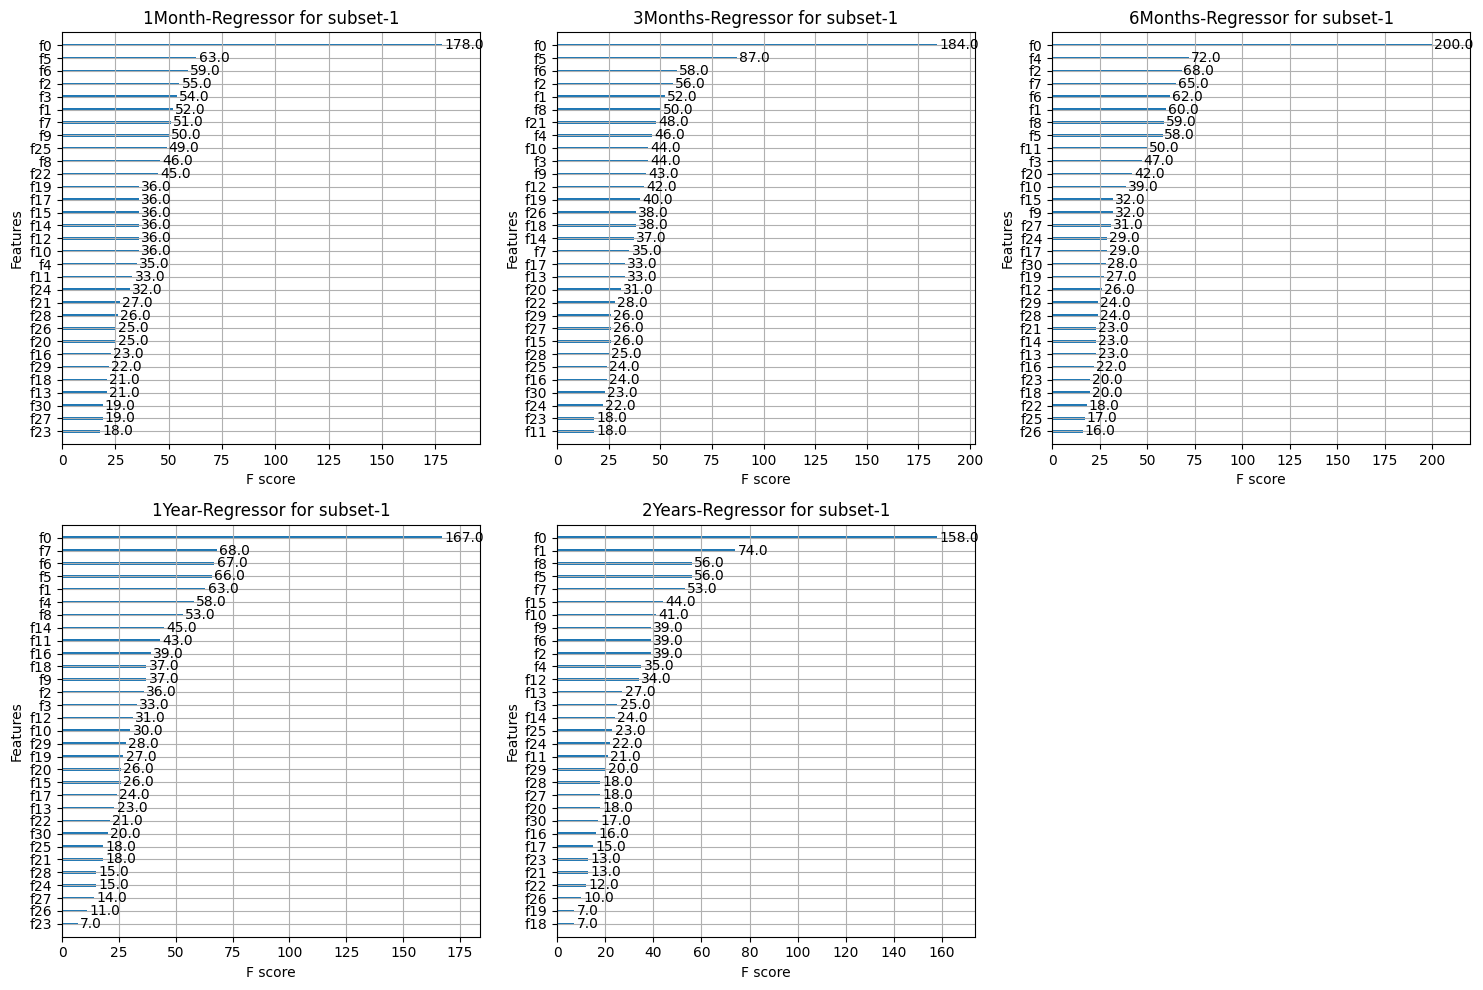

In [ ]:
for index in regressors:
    rgs = []
    for key in regressors[index].keys():
        rgs.append({'regressor': regressors[index][key]['regressor'],'key': key, 'index': index})

    # Print feature importances
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    for rg, ax in zip(rgs, axes.flatten()):
        plot_importance(rg['regressor'],ax=ax)
        ax.title.set_text("{1}-Regressor for subset-{0}".format(rg['index'],rg['key']))
        # ax.xlabel.set_text('asdfas')
    # blanks last axis
    axes[1][2].axis('off')
    plt.tight_layout()  
    plt.show()

## Accuracy Precission Recall <a class="anchor" id="apr"></a>

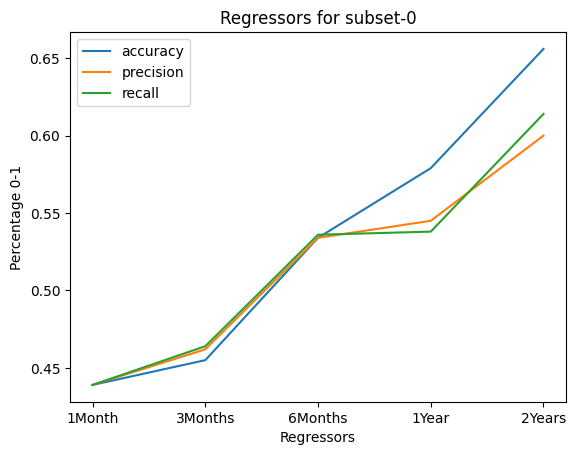

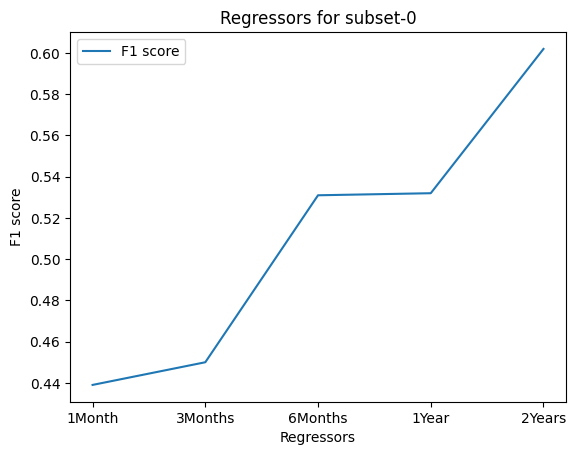

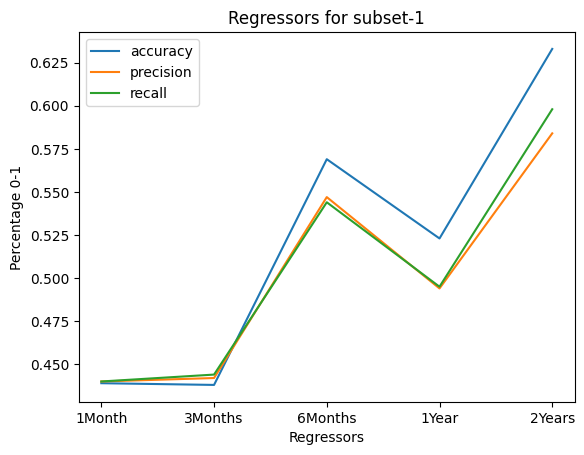

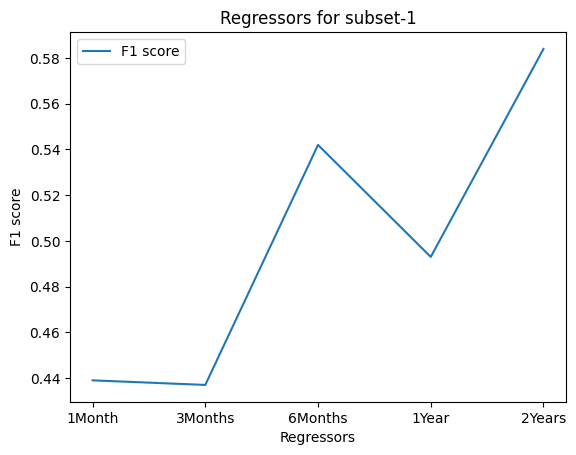

In [ ]:
    for index in regressors:
        rgs = []
        accuracy = []
        precision = []
        recall = []
        f_score = []
        for key, color in zip(regressors[index].keys(),bcolors):
            acc = round(metrics.accuracy_score(regressors[index][key]['y_test'],regressors[index][key]['y_pred']),3)
            prec = round(metrics.precision_score(regressors[index][key]['y_test'],regressors[index][key]['y_pred'],average="macro"),3)
            rec = round(metrics.recall_score(regressors[index][key]['y_test'],regressors[index][key]['y_pred'],average="macro"),3)
            f_s = round(metrics.f1_score(regressors[index][key]['y_test'],regressors[index][key]['y_pred'],average="macro"),3)
            accuracy.append(acc)
            precision.append(prec)
            recall.append(rec)
            f_score.append(f_s)
            if(enable_debug_prints):
                print("{0}Accuracy for Regresssor_{2}\t{3}:  \t {4}{1}".format(color,bcolors_end,index,key,acc))
                print("{0}Precision for Regresssor_{2}\t{3}:  \t {4}{1}".format(color,bcolors_end,index,key,prec))
                print("{0}Recall for Regresssor_{2}:\t{3}:  \t {4}{1}".format(color,bcolors_end,index,key,rec))

        fig, ax = plt.subplots()
        ax.plot(predict_variables, accuracy , label='accuracy')
        ax.plot(predict_variables, precision, label='precision')
        ax.plot(predict_variables, recall, label='recall')
        ax.set_xlabel('Regressors')  # Add an x-label to the Axes.
        ax.set_ylabel('Percentage 0-1')  # Add a y-label to the Axes.
        ax.set_title("Regressors for subset-{0}".format(index))  # Add a title to the Axes.
        ax.legend()  # Add a legend.
        # print(f_score)
        fig, ax = plt.subplots()
        ax.plot(predict_variables, f_score , label='F1 score')
        ax.set_xlabel('Regressors')  # Add an x-label to the Axes.
        ax.set_ylabel('F1 score')  # Add a y-label to the Axes.
        ax.set_title("Regressors for subset-{0}".format(index))  # Add a title to the Axes.
        ax.legend()  # Add a legend.


## Analyze trade runs <a class="anchor" id="analyze_trade_runs"></a>

profit: 193.1
 postive trades: 71
 negative trades: 48
amount of long trades: 1
 amount of short trades: 118
profit long trades: -13.5
 profit short trades: 206.6
profit: 193.7
 postive trades: 70
 negative trades: 47
amount of long trades: 4
 amount of short trades: 113
profit long trades: 43.2
 profit short trades: 150.5
profit: 292.8
 postive trades: 68
 negative trades: 43
amount of long trades: 1
 amount of short trades: 110
profit long trades: -32.8
 profit short trades: 325.6
profit: 20.7
 postive trades: 61
 negative trades: 40
amount of long trades: 2
 amount of short trades: 99
profit long trades: -207.5
 profit short trades: 228.2
profit: -1898.9
 postive trades: 44
 negative trades: 41
amount of long trades: 2
 amount of short trades: 83
profit long trades: 48.3
 profit short trades: -1947.2
profit: 193.1
 postive trades: 71
 negative trades: 48
amount of long trades: 8
 amount of short trades: 111
profit long trades: -69.5
 profit short trades: 262.6
profit: 193.7
 postive

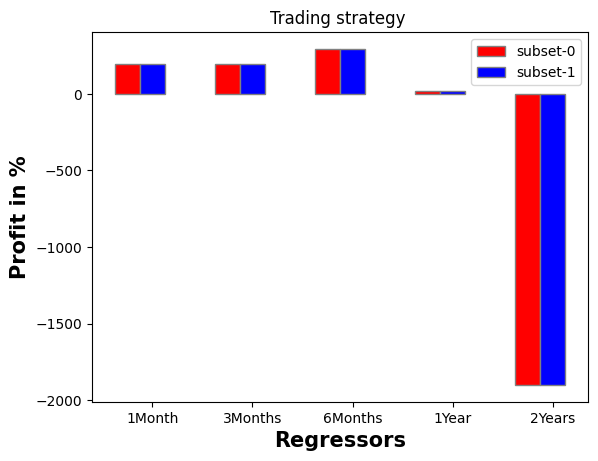

In [233]:
if(enable_debug_prints):
    for index in regressors:
        for key, color in zip(regressors[index].keys(),bcolors):
            parsed_result = list(evalute_overall_profit(regressors[index][key]['trading_result']).values()) 
            # print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd,1)))
            print("{0}profit: {2}\n postive trades: {3}\n negative trades: {4}{1}".format(color,bcolors_end,round(parsed_result[0],1),parsed_result[1],parsed_result[2]))
            print("{0}amount of long trades: {2}\n amount of short trades: {3}{1}".format(color,bcolors_end,parsed_result[3],parsed_result[4]))
            print("{0}profit long trades: {2}\n profit short trades: {3}{1}".format(color,bcolors_end,round(parsed_result[5],1),round(parsed_result[6],1)))

# Get the data for each variable and subset
bars = []
for variable in predict_variables:
    entries = []
    for index in regressors:
        entries.append(evalute_overall_profit(regressors[index][variable]['trading_result'])['total'])
    bars.append(entries)
# transpose it for plot
bars = np.transpose(bars)

# plot a bar for each subset and add the data
barWidth = 0.25
fig = plt.subplots() 
# fig = plt.subplots(figsize =(12, 8)) 
bar_index = 0
bar_pos = np.arange(len(bars[0])) 
colors = ['r', 'b']
for bar, variable, color in zip(bars,predict_variables,colors):
    if bar_index > 0:
        bar_pos = [x + barWidth for x in bar_pos]
    plt.bar(bar_pos, bar, color =color, width = barWidth, 
        edgecolor ='grey', label ="subset-{}".format(bar_index)) 
    bar_index += 1

#%Todo
plt.title('Trading strategy {0}'.format(''))
plt.xlabel('Regressors', fontweight ='bold', fontsize = 15) 
plt.ylabel('Profit in %', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(bars[0]))], 
        predict_variables)
 
plt.legend()
plt.show() 
